# Denoising Diffusion Model

The diffusion model is a type of latent variable model that can be viewed as an evolved version of the hierarchical Variational Autoencoder (VAE). Implementing a diffusion model requires only a few modifications to the hierarchical VAE, yet it yields remarkably superior generative performance. The key changes include:

1. **Dimensional Parity Between Latent and Observed Variables:** Both latent and observed variables share the same number of dimensions.
2. **Simplified Encoder as a Noise-Adding Module:** The encoder functions merely as a mechanism to add Gaussian noise, sourced from a fixed normal distribution.


![Figure 9](../figures/chapter4/part3-denoising-diffusion.png)

The fundamental concept behind the diffusion model is to learn the distribution of observed data through a ***denoising process***. The diffusion model operates in two main phases: ***diffusion*** and ***denoising***.

- During the **diffusion process**, the observed data is incrementally corrupted by repeatedly adding noise from a fixed normal distribution until it is transformed into pure noise.
- In the **denoising process**, a neural network is trained to predict the noise that was added to the data. Through this predictive denoising process, the original data is progressively reconstructed.


## Diffusion

![Diffusion](../figures/chapter4/part3-diffusion.png)

In the diffusion process, noise is progressively added to the data at each time step, building on the noise added in the previous step. The noise addition is calibrated such that by the final time step, the data resembles latent variables, essentially being destroyed. Typically, the latent variable at the final step, $x_T$, is assumed to follow a fixed normal distribution, denoted as $\mathcal{N}(x_T; 0, \text{I})$. This approach mirrors the assumption in Variational Autoencoders (VAEs) that latent variables are derived from a normal distribution.

The modeling of the diffusion process is defined for each time step $1 \leq t \leq T$ as follows.

$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1}, \beta_t\text{I})
$$

If $\beta_t$ is set to a small value such as 0.001 and $T$ is set sufficiently large, the distribution of $x_t$ can be made close to a normal distribution.

In fact, $x_t$ can be obtained using the following variable transformation trick.

$$\epsilon\sim\mathcal{N}(\epsilon;0,\text{I})\\x_t = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\epsilon$$

## Denoising

In the denoising process of the diffusion model, a neural network is employed. Given that all latent and observed variables share the same dimensional space in the diffusion model, the same neural network architecture can be utilized for denoising at each time point. The denoising process can be modeled as follows.

$$\hat{x}_{t-1} = \text{NeuralNetwork}(x_t,t;\theta)\\p_\theta(x_{t-1}|x_t) =\mathcal{N}(x_{t-1};\hat{x}_{t-1},\text{I})$$

## Parameters Estimation

Parameters estimation in a diffusion model is also performed by maximizing the log-likelihood function. In the diffusion model, the parameters are those of the neural network used in the denoising process. However, since it is difficult to compute the log-likelihood of a diffusion model, similar to the VAE, ELBO is used.

First, let’s calculate the ELBO of the diffusion model.

$$\begin{align*}\text{ELBO}(x_0;\theta) &= \int q(x_{1:T}|x_0)\log\frac{p_{\theta}(x_{0:T})}{q(x_{1:T}|x_0)}dx_{1:T} \\
&=  \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log\frac{p_{\theta}(x_{0:T})}{q(x_{1:T}|x_0)}\right] \\&= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log\frac{p(x_{T})\prod_{t=1}^{T}{p_{\theta}(x_{t-1}|x_t)}}{\prod_{t=1}^{T}{q(x_{t}|x_t-1)}}\right] \\&= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log{\prod_{t=1}^{T}{p_{\theta}(x_{t-1}|x_t)}} + \log{\frac{p(x_T)}{\prod_{t=1}^{T}{q(x_{t}|x_t-1)}}}\right]\end{align*}$$

Here, since the last time step data is a complete noise which follow a normal distribution, $p(x_T) $ is not a function of $\theta$. Therefore, maximizing ELBO is equivalent to maximizing the following function.

$$\begin{align*}    J(\theta) &= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log{\prod_{t=1}^{T}{p_{\theta}(x_{t-1}|x_t)}} \right] \\    &= \mathbb{E}_{q(x_{1:T}|x_0)}\left[{\sum_{t=1}^{T}\log{p_{\theta}(x_{t-1}|x_t)}} \right] \\    &= \sum_{t=1}^{T}\mathbb{E}_{q(x_{1:T}|x_0)}\left[{\log{p_{\theta}(x_{t-1}|x_t)}} \right] \\    &= \sum_{t=1}^{T}\mathbb{E}_{q(x_{t-1}, x_t|x_0)}\left[{\log{p_{\theta}(x_{t-1}|x_t)}} \right] \\    \end{align*}$$

$\mathbb{E}_{q(x_{t-1}, x_t|x_0)}[\cdot]$ can be approximated with Monte Carlo method and together with the modeling of denoising process, this function can be further approximated as follows.

$$\begin{align*}
J(\theta) &\approx \sum_{t=1}^{T}\log p_\theta(x_{t-1}|x_t) \\ \\    
\hat{x}_{t-1} &= \text{NeuralNet}(x_t,t;\theta) \\    p_\theta(x_{t-1}|x_t) &= \mathcal{N}(x_{t-1};\hat{x}_{t-1},\mathbf{I})\\ \\    J(\theta) &\approx -\frac{1}{2}\sum_{t=1}^{T}||x_{t-1}-\hat{x}_{t-1}||^2    \end{align*}$$

![Estimate Latent Variable](../figures/chapter4/part3-diffusion-est-latent.png)

Maximizing this $J(\theta)$ is equivalent to minimizing loss between $x_{t-1}$ and denoised $\hat{x}_{t-1}$. This means we train the neural network to conduct the denoising process given time step $t$ and corresponding data $x_t $ as inputs. However, as you may have noticed, each time of $J(\theta)$ calculation, we need to do $T$ times diffusion process sampling. This leads to high computational cost when we have large value of $T$ set. To make the process more efficient, another method of approximation method can be considered by using only one sampling of the diffusion process.

### Noise Prediction

The idea of this method is to train the neural network in denoising process to predict the noise $\hat\epsilon$added to the data, instead of predicting the data $\hat{x}_{t-1}$. 

![noise prediction](../figures/chapter4/part3-diffusion-est-noise.png)

We will mathematical show that training the neural network to predict the noise is equivalent to the previous approximation with $T$ times samplings in the previous section. 

Note that the distribution $p_\theta(x_{t-1}|x_t)$  can be modeled as

$$\begin{align*}
p_\theta(x_{t-1}|x_t)  &= \mathcal{N}(x_{t-1};\mu_\theta(x_t,t),\sigma_{q}^2(t)\text{I})
\end{align*}$$

$$\begin{align*}
\mu_\theta(x_t,t) &= \text{NeuralNetwork}(x_t, t)
\end{align*}$$

Let’s start from the modeling of the diffusion process. 

$$\begin{align*}
q(x_t|x_{t-1}) &= \mathcal{N}(x_t;\sqrt{{\alpha}_t}x_{t-1},(1-\alpha_t)\text{I}) ~~~,\text{where}~\alpha_t = 1-\beta_t \\
q(x_t|x_0) &= \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t}x_0,(1-\bar\alpha_t)\text{I}) ~~~,\text{where}~\bar\alpha_t = \prod_{t=1}^{T}(1-\beta_t) \\
\end{align*}$$

Thus, $x_t$ can be sampled as follows.

$$\begin{align*}
\epsilon &\sim \mathcal{N}(0, \text{I}) \\
x_t &= \sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar\alpha_t}\epsilon 
\end{align*}$$

Now, we can express the original observed data $x_0$ as

$$\begin{align*}
x_0 &= \frac{x_t-\sqrt{1-\bar\alpha_t}\epsilon}{\sqrt{\bar\alpha_t}}  
\end{align*}$$

Given $x_0$ and $x_t$, the distribution of $x_{t-1}$ can be obtained as follows.

$$\begin{align*}
q(x_{t-1}|x_t,x_0) &= \frac{q(x_t|x_{t-1},x_0)q(x_{t-1}|x_0)}{q(x_t|x_0)}
\end{align*}$$

With Markov assumption, $q(x_t|x_{t-1},x_0) = q(x_t|x_{t-1})$

$$\begin{align*}
q(x_{t-1}|x_t,x_0) &= \frac{q(x_t|x_{t-1})q(x_{t-1}|x_0)}{q(x_t|x_0)} \\
&=\frac{\mathcal{N}(x_t;\sqrt{{\alpha}_t}x_{t-1},(1-\alpha_t)\text{I}) ~ \mathcal{N}(x_{t-1};\sqrt{\bar{\alpha}_{t-1}}x_0,(1-\bar\alpha_{t-1})\text{I}) }{\mathcal{N}(x_t;\sqrt{\bar{\alpha}_t}x_0,(1-\bar\alpha_t)\text{I}) }
\end{align*}$$

By expanding the right side of this equation, we obtain the following distribution.

$$\begin{align*}
q(x_{t-1}|x_t,x_0) &= \mathcal{N}\left(x_{t-1}; \mu_q(x_t,x_0), \sigma_q^2(t)\text{I}\right) \\
\mu_q(x_t,x_0) &= \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}\epsilon\right) \\
\sigma_q^2(t) &= \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}
\end{align*}$$

Here, let’s rewrite $\mu_\theta(x_t,t)$ to match the form of $\mu_q(x_t,x_0)$ as

$$\begin{align*}
\mu_\theta(x_t,t) &= \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t)\right)
\end{align*}$$

, where now we set the output of the neural network to $\epsilon_\theta(x_t, t)$ instead.

Now, let’s look back to the KL divergence between the two normal distributions $q(x_{t-1}|x_t,x_0)$ and $p_\theta(x_{t-1}|x_t)= \mathcal{N}(x_{t-1};\hat{x}_{t-1},\mathbf{I})$.

$$\begin{align*}
D_{\text{KL}}(q(x_{t-1}|x_t,x_0)\|p_\theta(x_{t-1}|x_t)) &= \frac{1}{2\sigma_q^2(t)}\|\mu_\theta(x_t,t) - \mu_q(x_t,x_0)\|^2 \\
&= \frac{1}{2\sigma_q^2(t)}\|\epsilon_\theta(x_t,t) - \epsilon\|^2
\end{align*}$$

This shows that by train the neural network to predict the noise, which is minimizing the above KL divergence, lead to maximizing the EBOL of the diffusion model. Thus, this optimization is equivalent to the parameter estimation with $T$ times sampling in the previous section.

To sum up, the training algorithm of the diffusion model is as follows.

```{admonition} Training Algorithm
Repeat the following steps:

1. Randomly sample a training data instance
2. Sample a time step $t$ from a uniform distribution : $t \sim U[1,T]$ 
3. Generate Gaussian noise for diffusion process: $\epsilon \sim \mathcal{N}(0,\text{I})$
4. Diffusion process: $x_t = \sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar\alpha_t}\epsilon$
5. Calculate loss: $\text{Loss}(x_0, \theta) = \|\epsilon_\theta(x_t,t)-\epsilon\|^2$
6. Update parameters $\theta$ with gradient decent
```

## Generating New Data

As shown in previous sections, the denoising process is modeled as follows.

$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1};\mu_\theta(x_t,t),\sigma_q^2(t)\text{I})$$

Using the following trick, we can sample every time step data with the following process.

$$\begin{align*}
\epsilon &\sim \mathcal{N}(0, I) \\
x_{t-1} &= \mu_\theta(x_t,t)+\sigma_q(t)\epsilon
\end{align*}$$

Here, 

$$\begin{align*}
\mu_\theta(x_t,t) &= \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t)\right) \\
\sigma_q(t)&=\sqrt{\frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}}
\end{align*}$$

. Thus, the process of new data generation can be summarized as follows.

```{admonition} Generation Process
$x_T \sim \mathcal{N}(0,\text{I})$

for $t$ in $[T,...,1]$:

$\epsilon\sim\mathcal{N}(0,\text{I})$

if $t=1$ then $\epsilon=0$

$\sigma_q(t)=\sqrt{\frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}}$

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t)\right) +\sigma_q(t)\epsilon$

return $x_0$
```

![diffusion generated](../figures/chapter4/part3-diffusion-generated.png)

## Implementation of Denoising Probabilistic Diffusion Model


[Jupyter Notebook](https://colab.research.google.com/drive/1leq-Ke1WpSeujoYFVCEGAByTYaEJ7A1X?usp=sharing)

### Data Preparation

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
def prepare_dataset(batch_size):
    preprocessor = transforms.ToTensor()
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=preprocessor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [3]:
batch_size = 128

dataloader = prepare_dataset(batch_size)

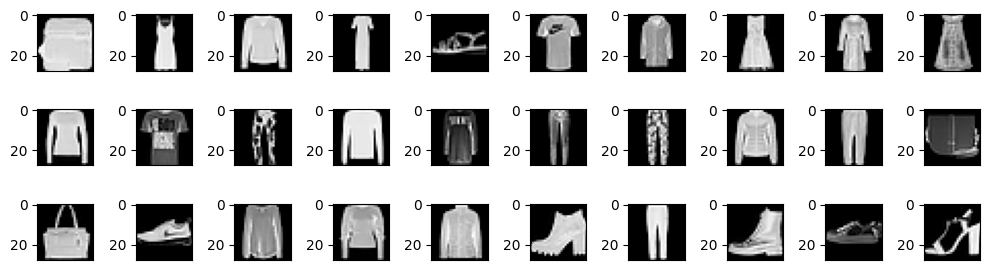

In [4]:
import matplotlib.pyplot as plt

def show_images(images, labels=None, cols=10, rows=3):
    figures = plt.figure(figsize=(cols, rows))
    idx = 0
    for r in range(rows):
        for c in range(cols):
          ax = figures.add_subplot(rows, cols, idx+1)
          plt.imshow(images[idx], cmap="gray")

          if labels is not None:
            ax.set_xlabel(labels[idx])
          ax.get_xaxis().set_ticks([])
          ax.get_xaxis().set_ticks([])
          idx += 1

    plt.tight_layout()
    plt.show()

def save_images(images, labels=None, cols=10, rows=3, save_path="images.png"):
    figures = plt.figure(figsize=(cols, rows))
    idx = 0
    for r in range(rows):
        for c in range(cols):
          ax = figures.add_subplot(rows, cols, idx+1)
          plt.imshow(images[idx], cmap="gray")

          if labels is not None:
              ax.set_xlabel(labels[idx])
          ax.get_xaxis().set_ticks([])
          ax.get_xaxis().set_ticks([])
          idx += 1

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

data_iter = iter(dataloader)
images, labels = next(data_iter)
show_images([img[0] for img in images])

### Model Preparation

In [7]:
import torch
import torch.nn as nn

In [8]:
def time_embedding(time_steps, time_dim, device='cpu'):
    max_time = len(time_steps)
    embeddings = torch.zeros(max_time, time_dim, device=device)

    idx = torch.arange(0, time_dim, device=device)
    div_term = torch.exp(idx / (2 * time_dim) * torch.log(torch.tensor(10000.0)))

    for t in range(max_time):
        embeddings[t, 0::2] = torch.sin(time_steps[t] / div_term[::2])
        embeddings[t, 1::2] = torch.cos(time_steps[t]  / div_term[1::2])

    return embeddings

In [9]:
class ConvBlock(nn.Module):
    """
    A convolutional block with time embedding.
    """
    def __init__(self, in_channels, out_channels, time_dim):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            time_dim (int): Dimension of the time embedding.
        """
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.linear = nn.Sequential(
            nn.Linear(time_dim, in_channels*2),
            nn.ReLU(),
            nn.Linear(in_channels*2, in_channels)
        )

    def forward(self, x, t=None):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        if t is not None:
            t = self.linear(t)
            t = t.view(x.size(0), -1, 1, 1)
            x = x + t
        x = self.conv(x)

        return x


class UNetWithTime(nn.Module):
    """
    A U-Net model with time embedding.
    """
    def __init__(self, in_channels=1, out_channels=1, time_dim=512):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            time_dim (int): Dimension of the time embedding.
        """
        super(UNetWithTime, self).__init__()
        self.time_dim = time_dim

        self.time_embedding = time_embedding
        # down sampling
        self.down_conv1 = ConvBlock(in_channels, 64, time_dim)
        self.down_conv2 = ConvBlock(64, 128, time_dim)
        # bottleneck
        self.bottleneck = ConvBlock(128, 256, time_dim)
        # up sampling
        self.up_conv2 = ConvBlock(256+128, 128, time_dim) # concat with down sampling
        self.up_conv1 = ConvBlock(128+64, 64, time_dim) # concat with down sampling
        # output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        # max pooling
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # up sampling
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, time_steps):
        """
        Args:
            x (torch.Tensor): Input tensor.
            time_steps (torch.Tensor): Time steps.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        t = self.time_embedding(time_steps, self.time_dim, device=x.device)
        x1 = self.down_conv1(x, t)
        x = self.max_pool(x1)
        x2 = self.down_conv2(x, t)
        x = self.max_pool(x2)
        x = self.bottleneck(x, t)
        x = self.up_sample(x)
        x = self.up_conv2(torch.cat([x, x2], dim=1), t)
        x = self.up_sample(x)
        x = self.up_conv1(torch.cat([x, x1], dim=1), t)
        x = self.out(x)

        return x

### Diffusion and Denoising

In [10]:
from tqdm import tqdm

class Diffuser:
    def __init__(self, max_steps, beta_start=0.001, beta_end=0.01, device='cpu'):
        """
        Args:
            max_steps (int): Maximum number of steps in diffusion step.
            beta_start (float): Initial value of beta.
            beta_end (float): Final value of beta.
        """
        self.device = device
        self.max_steps = max_steps
        self.betas = torch.linspace(beta_start, beta_end, max_steps, device=self.device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = self.alphas.cumprod(dim=0)

    def diffuse(self, x, t):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        noise = torch.randn_like(x, device=self.device)
        alpha_cumprod = self.alphas_cumprod[t-1].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_cumprod) * x + torch.sqrt(1 - alpha_cumprod) * noise

        return x_t, noise

    def denoise(self, model, x, t):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        _t = t-1
        alpha = self.alphas[_t].view(-1, 1, 1, 1)
        alpha_cumprod = self.alphas_cumprod[_t].view(-1, 1, 1, 1)
        alpha_cumprod_prev = self.alphas_cumprod[_t-1].view(-1, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            pred_noise = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_cumprod)) * pred_noise) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_cumprod_prev) / (1-alpha_cumprod))
        return mu + noise * std

    def convert_to_image(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        return x

    def sample(self, model, sample_shape=(1, 1, 28, 28)):
        bsz = sample_shape[0]
        x = torch.randn(sample_shape, device=self.device)

        for i in tqdm(range(self.max_steps, 0, -1)):
            t = torch.tensor([i] * bsz, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)

        x = torch.stack([self.convert_to_image(x[i]) for i in range(bsz)])
        return x


### Training

In [11]:
import os
from torch.optim import Adam
import torch.nn.functional as F

In [12]:
def train():
    # Hyperparameters
    in_channels = 1
    img_size = 28
    batch_size = 128
    max_steps = 1000
    time_dim = 100
    lr = 1e-3
    epochs = 10
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'

    # Prepare dataset
    dataloader = prepare_dataset(batch_size)

    # Initialize model and diffuser
    model = UNetWithTime(in_channels=in_channels, time_dim=time_dim).to(device)
    diffuser = Diffuser(max_steps=max_steps, device=device)
    optimizer = Adam(model.parameters(), lr=lr)

    # Training loop
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        cnt = 0

        images = diffuser.sample(model, (64, 1, img_size, img_size))
        print(len(images))
        show_images([img[0] for img in images.to('cpu')])

        os.makedirs("data/FashionMNIST/generated", exist_ok=True)
        save_images([img[0] for img in images.to('cpu')], save_path=f"data/FashionMNIST/generated/images_{epoch}.png")

        for images, labels in tqdm(dataloader):
            optimizer.zero_grad()
            x = images.to(device)
            t = torch.randint(1, max_steps+1, (len(x),), device=device)

            x_noisy, noise = diffuser.diffuse(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise, noise_pred)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            cnt += 1

        loss_avg = loss_sum / cnt
        losses.append(loss_avg)
        print(f'Epoch {epoch} | Loss: {loss_avg}')

    # save model
    torch.save(model.state_dict(), "data/FashionMNIST/model.pth")

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.savefig("data/FashionMNIST/generated/loss.png")
    plt.close()

    images = diffuser.sample(model, (batch_size, 1, img_size, img_size))
    show_images([img[0] for img in images.to('cpu')])
    save_images([img[0] for img in images.to('cpu')], save_path="data/FashionMNIST/generated/images.png")


100%|██████████| 1000/1000 [00:34<00:00, 29.31it/s]


64


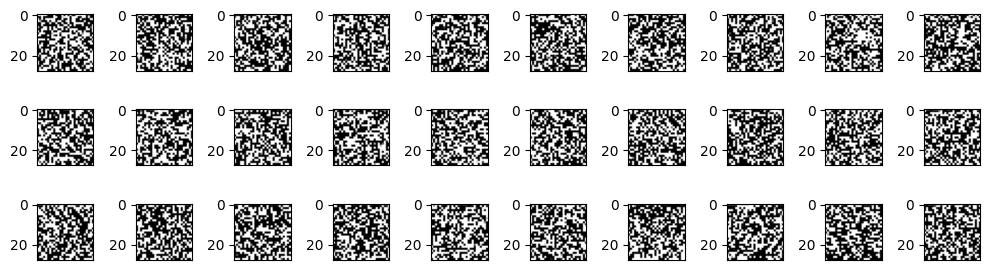

100%|██████████| 469/469 [00:44<00:00, 10.59it/s]


Epoch 0 | Loss: 0.051879276761781175


100%|██████████| 1000/1000 [00:31<00:00, 31.44it/s]


64


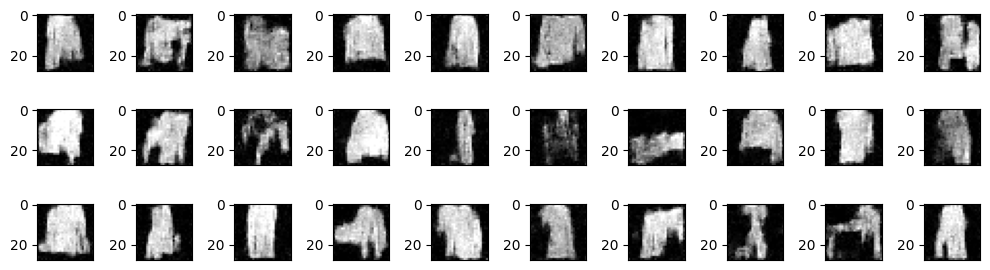

100%|██████████| 469/469 [00:41<00:00, 11.42it/s]


Epoch 1 | Loss: 0.03249755171713417


100%|██████████| 1000/1000 [00:31<00:00, 31.64it/s]


64


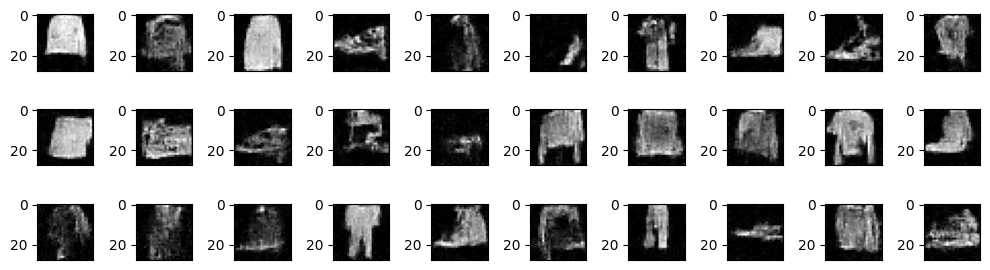

100%|██████████| 469/469 [00:41<00:00, 11.22it/s]


Epoch 2 | Loss: 0.028978557935528663


100%|██████████| 1000/1000 [00:31<00:00, 31.62it/s]


64


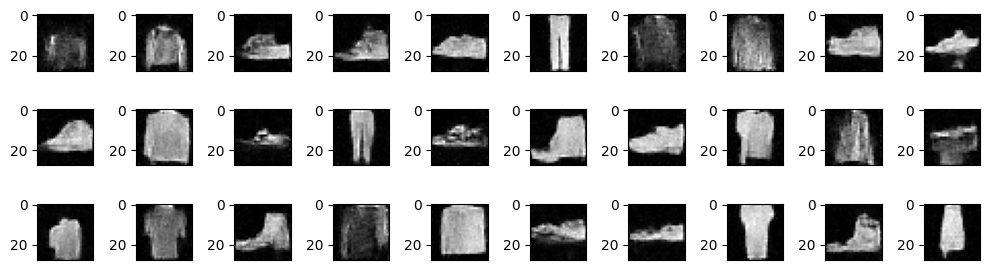

100%|██████████| 469/469 [00:40<00:00, 11.46it/s]


Epoch 3 | Loss: 0.02690664654188573


100%|██████████| 1000/1000 [00:31<00:00, 31.66it/s]


64


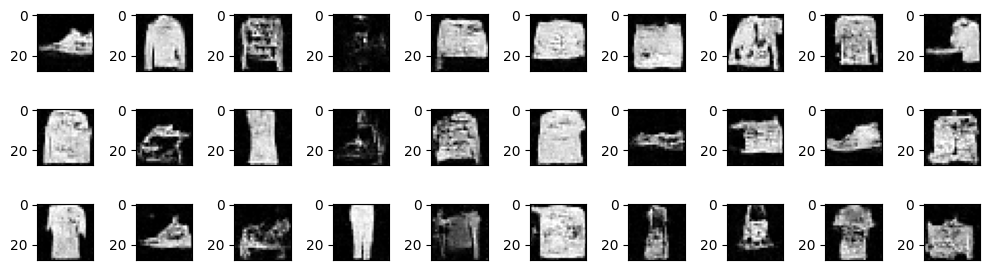

100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


Epoch 4 | Loss: 0.02600087759607255


100%|██████████| 1000/1000 [00:31<00:00, 31.52it/s]


64


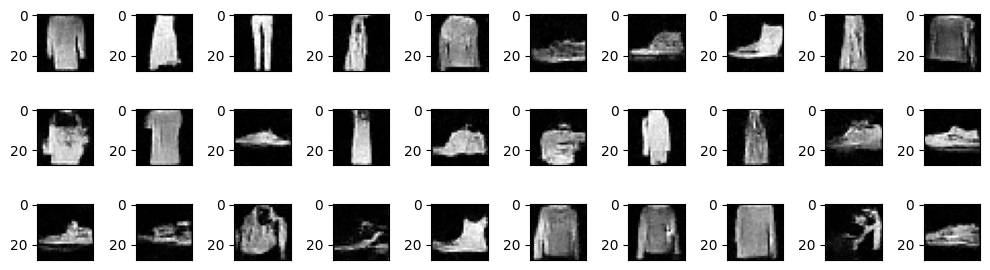

100%|██████████| 469/469 [00:41<00:00, 11.37it/s]


Epoch 5 | Loss: 0.024961892352588395


100%|██████████| 1000/1000 [00:31<00:00, 31.55it/s]


64


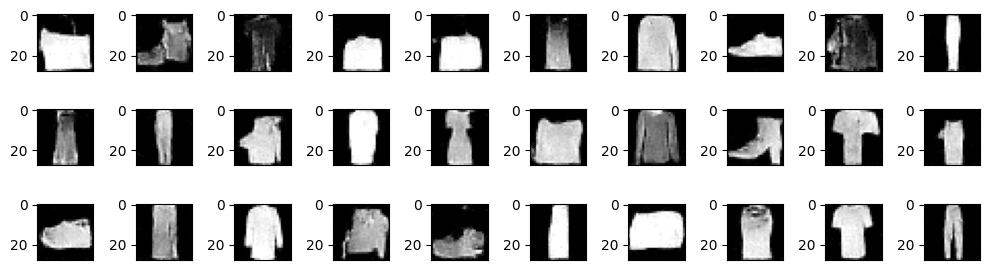

100%|██████████| 469/469 [00:41<00:00, 11.43it/s]


Epoch 6 | Loss: 0.02460486056612753


100%|██████████| 1000/1000 [00:31<00:00, 31.47it/s]


64


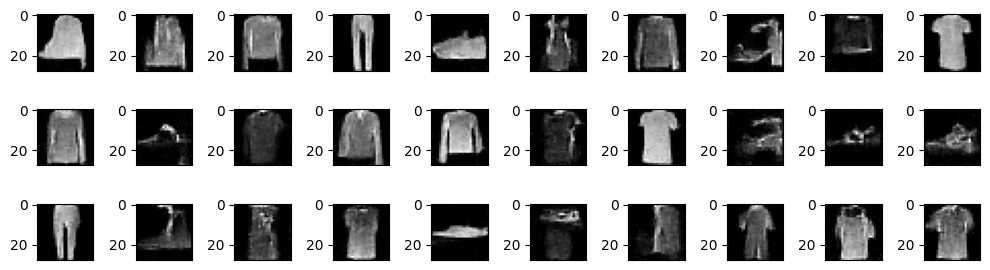

100%|██████████| 469/469 [00:40<00:00, 11.49it/s]


Epoch 7 | Loss: 0.024157190147334577


100%|██████████| 1000/1000 [00:31<00:00, 31.66it/s]


64


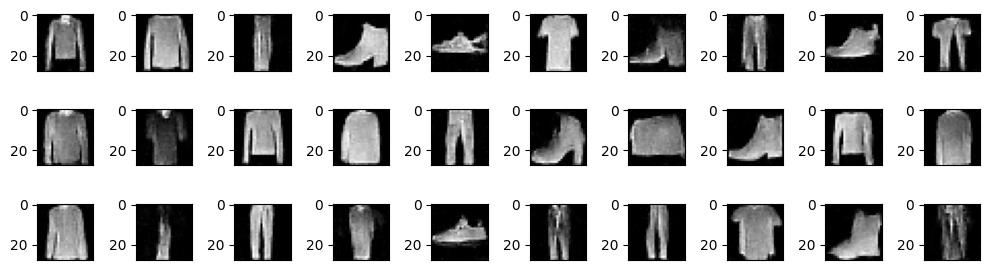

100%|██████████| 469/469 [00:39<00:00, 11.73it/s]


Epoch 8 | Loss: 0.023824092985661044


100%|██████████| 1000/1000 [00:31<00:00, 31.62it/s]


64


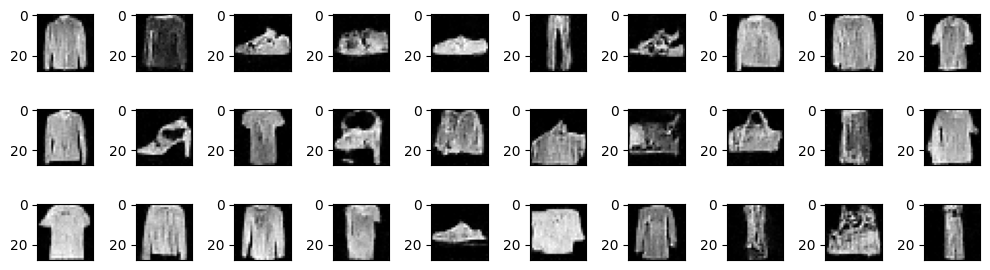

100%|██████████| 469/469 [00:39<00:00, 11.76it/s]


Epoch 9 | Loss: 0.023547933498488816


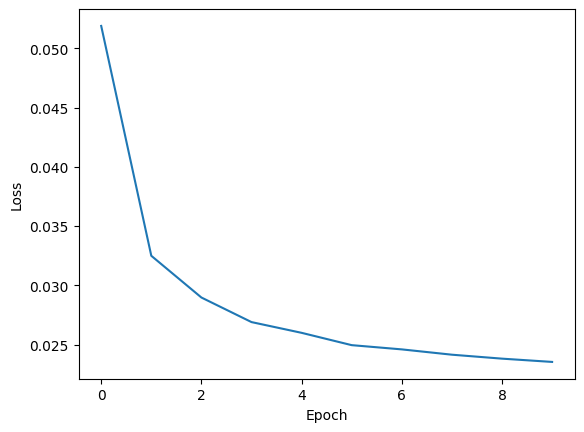

100%|██████████| 1000/1000 [00:58<00:00, 17.19it/s]


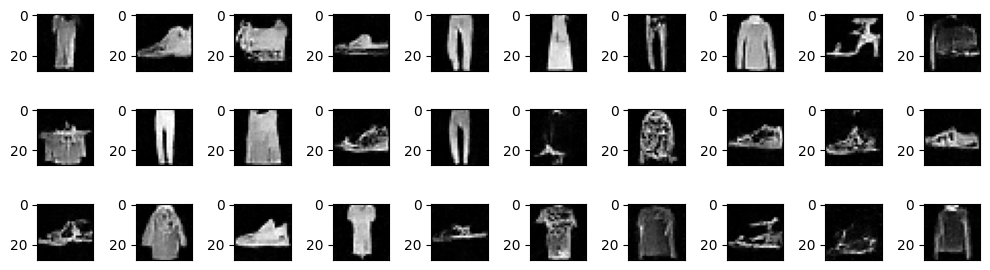

In [13]:
train()